In [77]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pandas as pd

def generate_stochastic_series(
    n=500,
    ar_params=[0.75],          # AR coefficients (e.g., AR(1): [0.75])
    ma_params=[-0.25],         # MA coefficients (e.g., MA(1): [-0.25])
    d=1,                       # Differencing order (I(d) component)
    noise_std=0.05,
    seed=None
):
    if seed is not None:
        np.random.seed(seed)

    # Add leading 1 for statsmodels convention
    ar = np.r_[1, -np.array(ar_params)]
    ma = np.r_[1, np.array(ma_params)]

    arma_process = ArmaProcess(ar, ma)

    # Generate ARMA sample
    arma_sample = arma_process.generate_sample(nsample=n + d, scale=noise_std)

    # Apply differencing if needed
    if d > 0:
        for _ in range(d):
            arma_sample = np.cumsum(arma_sample)

    # Create DataFrame
    df_stochastic = pd.DataFrame({
        'value': arma_sample[d:]
    }, index=np.arange(n))

    return df_stochastic

# Generate example ARIMA(1,1,1) process
df_stochastic_example = generate_stochastic_series(
    n=500,
    ar_params=[0.75],
    ma_params=[-0.25],
    d=1,
    noise_std=1.0,
    seed=42
)

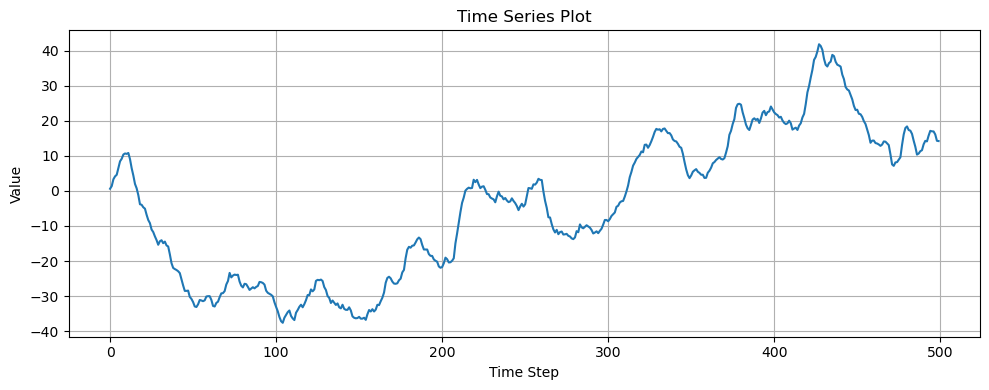

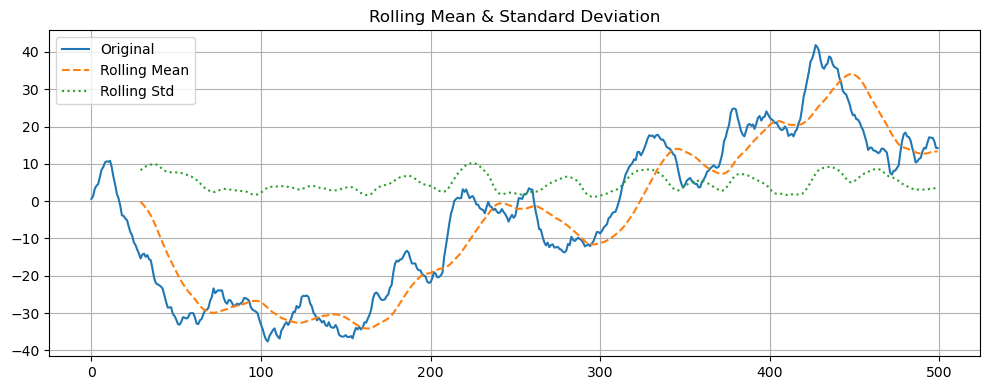

/var/folders/7c/12d1bdbs4cvbh7zksb_8wcgw0000gn/T/ipykernel_53257/412454805.py:29: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


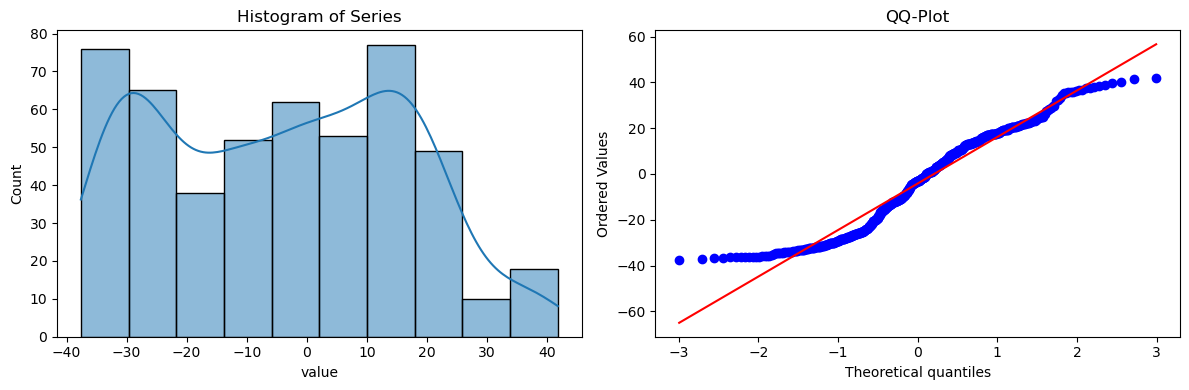

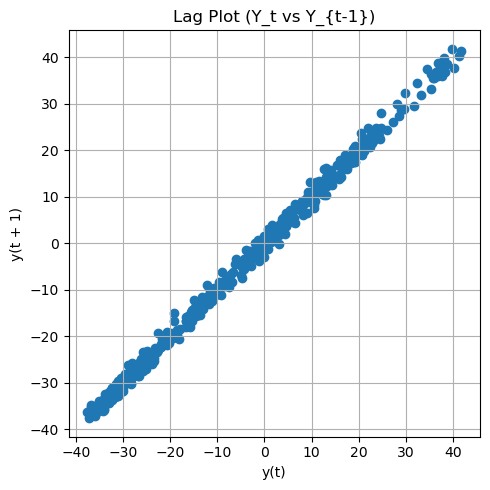

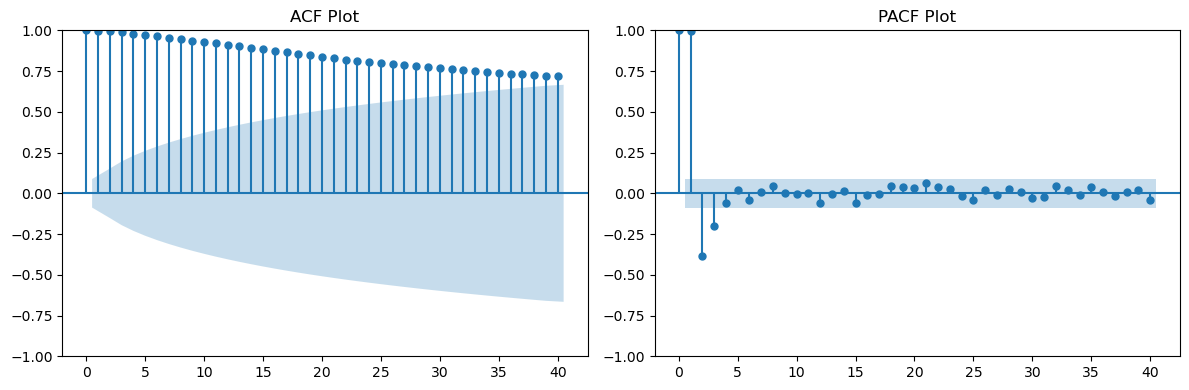

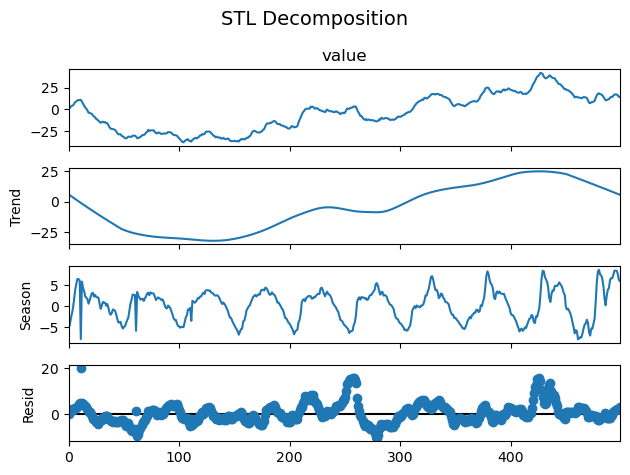

In [78]:
series = df_stochastic_example['value']

# 1. Line Plot
plt.figure(figsize=(10, 4))
plt.plot(series)
plt.title("Time Series Plot")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Rolling Mean and Std
rolling_mean = series.rolling(window=30).mean()
rolling_std = series.rolling(window=30).std()

plt.figure(figsize=(10, 4))
plt.plot(series, label='Original')
plt.plot(rolling_mean, label='Rolling Mean', linestyle='--')
plt.plot(rolling_std, label='Rolling Std', linestyle=':')
plt.title("Rolling Mean & Standard Deviation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. ADF and KPSS Tests
adf_result = adfuller(series)
kpss_result = kpss(series, regression='c', nlags='auto')

adf_output = {
    'ADF Statistic': adf_result[0],
    'p-value': adf_result[1],
    'Used Lags': adf_result[2],
    'Observations': adf_result[3]
}

kpss_output = {
    'KPSS Statistic': kpss_result[0],
    'p-value': kpss_result[1],
    'Used Lags': kpss_result[2]
}

# 4. Histogram & QQ-Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(series, kde=True, ax=axes[0])
axes[0].set_title("Histogram of Series")
stats.probplot(series, dist="norm", plot=axes[1])
axes[1].set_title("QQ-Plot")
plt.tight_layout()
plt.show()

# 5. Lag Plot
plt.figure(figsize=(5, 5))
lag_plot(series)
plt.title("Lag Plot (Y_t vs Y_{t-1})")
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. ACF & PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(series, ax=axes[0], lags=40)
plot_pacf(series, ax=axes[1], lags=40)
axes[0].set_title("ACF Plot")
axes[1].set_title("PACF Plot")
plt.tight_layout()
plt.show()

# 7. STL Decomposition
stl = STL(series, period=50, robust=True)
stl_result = stl.fit()
stl_result.plot()
plt.suptitle("STL Decomposition", fontsize=14)
plt.tight_layout()
plt.show()

# Display ADF and KPSS results
test_results_df = pd.DataFrame([adf_output, kpss_output], index=["ADF Test", "KPSS Test"])

In [79]:
# Use the generated synthetic ARIMA(1,1,1) series
series = generate_stochastic_series(
    n=500,
    ar_params=[0.75],
    ma_params=[-0.25],
    d=1,
    noise_std=1.0,
    seed=42
)['value']

# 70/30 time-aware train-test split
split_index = int(0.9 * len(series))
train_series = series[:split_index]
test_series = series[split_index:]

# Display info
train_info = {
    "Train Start Index": train_series.index[0],
    "Train End Index": train_series.index[-1],
    "Test Start Index": test_series.index[0],
    "Test End Index": test_series.index[-1],
    "Train Size": len(train_series),
    "Test Size": len(test_series),
    "Total Size": len(series)
}

split_summary = pd.DataFrame([train_info])
split_summary

,Train Start Index,Train End Index,Test Start Index,Test End Index,Train Size,Test Size,Total Size
0,0,449,450,499,450,50,500


In [80]:
# Define individual model creation functions

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.layers import Conv1D, MaxPooling1D, Flatten, Input
from keras.models import Model
import tensorflow as tf

# 1. ARIMA
def create_arima_model(train_series, order=(1, 1, 1)):
    return ARIMA(train_series, order=order)

# 2. SARIMA
def create_sarima_model(train_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
    return SARIMAX(train_series, order=order, seasonal_order=seasonal_order,
                   enforce_stationarity=False, enforce_invertibility=False)

# 3. SVR
def create_svr_model(C=1.0, epsilon=0.1, kernel='rbf'):
    return SVR(C=C, epsilon=epsilon, kernel=kernel)

# 4. XGBoost
def create_xgboost_model(n_estimators=100, max_depth=3, learning_rate=0.1):
    return XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)

# 5. LSTM
def create_lstm_model(input_shape, units=50):
    model = Sequential()
    model.add(LSTM(units, activation='tanh', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# 6. TCN
def create_tcn_model(input_shape, filters=64, kernel_size=3):
    model = Sequential()
    model.add(Conv1D(filters, kernel_size, activation='relu', padding='causal', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# 7. Transformer (simplified small version)
def create_transformer_model(input_shape, num_heads=2, ff_dim=32):
    inputs = Input(shape=input_shape)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(x, x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = Dense(ff_dim, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

In [81]:
"""
# Set parameters
arima_order = (1, 1, 1)
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)
svr_params = {'C': 1.0, 'epsilon': 0.1, 'kernel': 'rbf'}
xgb_params = {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}

# Deep model specific parameters
deep_input_shape = (10, 1)
lstm_params = {'input_shape': deep_input_shape, 'units': 50}
tcn_params = {'input_shape': deep_input_shape, 'filters': 64, 'kernel_size': 3}
transformer_params = {'input_shape': deep_input_shape, 'num_heads': 2, 'ff_dim': 32}
"""

# Initialize deep model input shape
deep_input_shape = (10, 1)

# Create each model with the respective parameters
model_dict = {
    'arima': create_arima_model(train_series, order=(1, 1, 1)),
    'sarima': create_sarima_model(train_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)),
    'svr': create_svr_model(C=1.0, epsilon=0.1, kernel='rbf'),
    'xgboost': create_xgboost_model(n_estimators=1000, max_depth=30, learning_rate=0.1),
    'lstm': create_lstm_model(input_shape=deep_input_shape, units=50),
    'tcn': create_tcn_model(input_shape=deep_input_shape, filters=64, kernel_size=3),
    'transformer': create_transformer_model(input_shape=deep_input_shape, num_heads=2, ff_dim=32)
}


/Users/edsonodake/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/edsonodake/miniforge3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [82]:
# Universal training function for all models
def train_model(model_name, model, train_series, lag=10, epochs=10, batch_size=32):
    if model_name in ['arima', 'sarima']:
        return model.fit()
    
    # Prepare lag features for ML/DL models
    X, y = [], []
    for i in range(lag, len(train_series)):
        X.append(train_series[i - lag:i])
        y.append(train_series[i])
    
    X = np.array(X)
    y = np.array(y)

    if model_name in ['svr', 'xgboost']:
        return model.fit(X, y)

    # Reshape for deep learning models: (samples, timesteps, features)
    X_dl = X.reshape((X.shape[0], X.shape[1], 1))

    if model_name in ['lstm', 'tcn', 'transformer']:
        model.fit(X_dl, y, epochs=epochs, batch_size=batch_size, verbose=0)
        return model

    raise ValueError(f"Unsupported model type: {model_name}")


In [83]:
# Train all models using the unified training function
trained_models = {}

# We'll use lag=10 and 10 epochs for deep learning models
for model_name, model in model_dict.items():
    trained_models[model_name] = train_model(
        model_name=model_name,
        model=model,
        train_series=train_series,
        lag=10,
        epochs=100,
        batch_size=32
    )

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44952D+00    |proj g|=  2.58183D-01

At iterate    5    f=  1.34463D+00    |proj g|=  2.62768D-03


 This problem is unconstrained.



At iterate   10    f=  1.34463D+00    |proj g|=  5.05505D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     16      1     0     0   5.055D-05   1.345D+00
  F =   1.3446250928457639     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [84]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import acf

# Enhanced evaluation function with more metrics
def evaluate_forecast(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    error = y_true - y_pred

    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = np.mean(np.abs(error / y_true)) * 100
    me = np.mean(error)
    mpe = np.mean(error / y_true) * 100
    acf1 = acf(error, nlags=1)[1] if len(error) > 1 else np.nan
    corr = pearsonr(y_true, y_pred)[0] if len(y_true) > 1 else np.nan
    minmax = np.mean(np.abs(error) / (np.maximum(np.abs(y_true), np.abs(y_pred)) + 1e-8))

    return {
        'ME': me,
        'MAE': mae,
        'MPE': mpe,
        'MAPE': mape,
        'RMSE': rmse,
        'ACF1': acf1,
        'corr': corr,
        'minmax': minmax
    }


# Prediction function
def predict_model(model_name, model, input_series, steps_ahead=10, lag=10):
    input_series = list(input_series[-lag:])  # Start with last lag window
    predictions = []

    if model_name in ['arima', 'sarima']:
        return model.forecast(steps=steps_ahead)

    for _ in range(steps_ahead):
        X_input = np.array(input_series[-lag:]).reshape(1, -1)

        if model_name in ['svr', 'xgboost']:
            pred = model.predict(X_input)[0]
        else:  # Deep models
            X_input = X_input.reshape((1, lag, 1))
            pred = model.predict(X_input, verbose=0)[0][0]

        predictions.append(pred)
        input_series.append(pred)

    return np.array(predictions)

In [85]:
results = {}
predictions = {}

for model_name, model in trained_models.items():
    try:
        y_pred = predict_model(
            model_name=model_name,
            model=model,
            input_series=train_series,
            steps_ahead=len(test_series),
            lag=10
        )
        predictions[model_name] = y_pred  # Save predictions for plotting later
        results[model_name] = evaluate_forecast(test_series, y_pred)
    except Exception as e:
        #results[model_name] = {'MAE': None, 'RMSE': None, 'MAPE': None, 'Error': str(e)}
        results[model_name] = {'MAE': None, 'RMSE': None, 'MAPE': None}
        predictions[model_name] = None

# Display evaluation results
results_df = pd.DataFrame(results).T
results_df

/Users/edsonodake/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/edsonodake/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/edsonodake/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/edsonodake/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be remove

,ME,MAE,MPE,MAPE,RMSE,ACF1,corr,minmax
arima,-5.297614,5.401647,-46.458122,46.926821,6.280423,0.893902,0.666748,0.275251
sarima,-5.488629,5.751865,-48.576455,49.816958,6.686901,0.895675,-0.024845,0.285898
svr,-5.358165,5.382030,-46.692499,46.795626,6.290862,0.891579,0.544741,0.273930
xgboost,-8.361565,8.380877,-69.751473,69.834927,9.144937,0.880455,-0.060141,0.366906
lstm,-6.650972,6.870830,-57.556206,58.570903,7.763980,0.909327,-0.384478,0.322215
tcn,2.734916,4.392667,15.455033,31.463972,5.695483,0.945952,0.390135,0.295221
transformer,15.629593,15.629593,108.553890,108.553890,16.061468,0.882833,NaN,1.085539


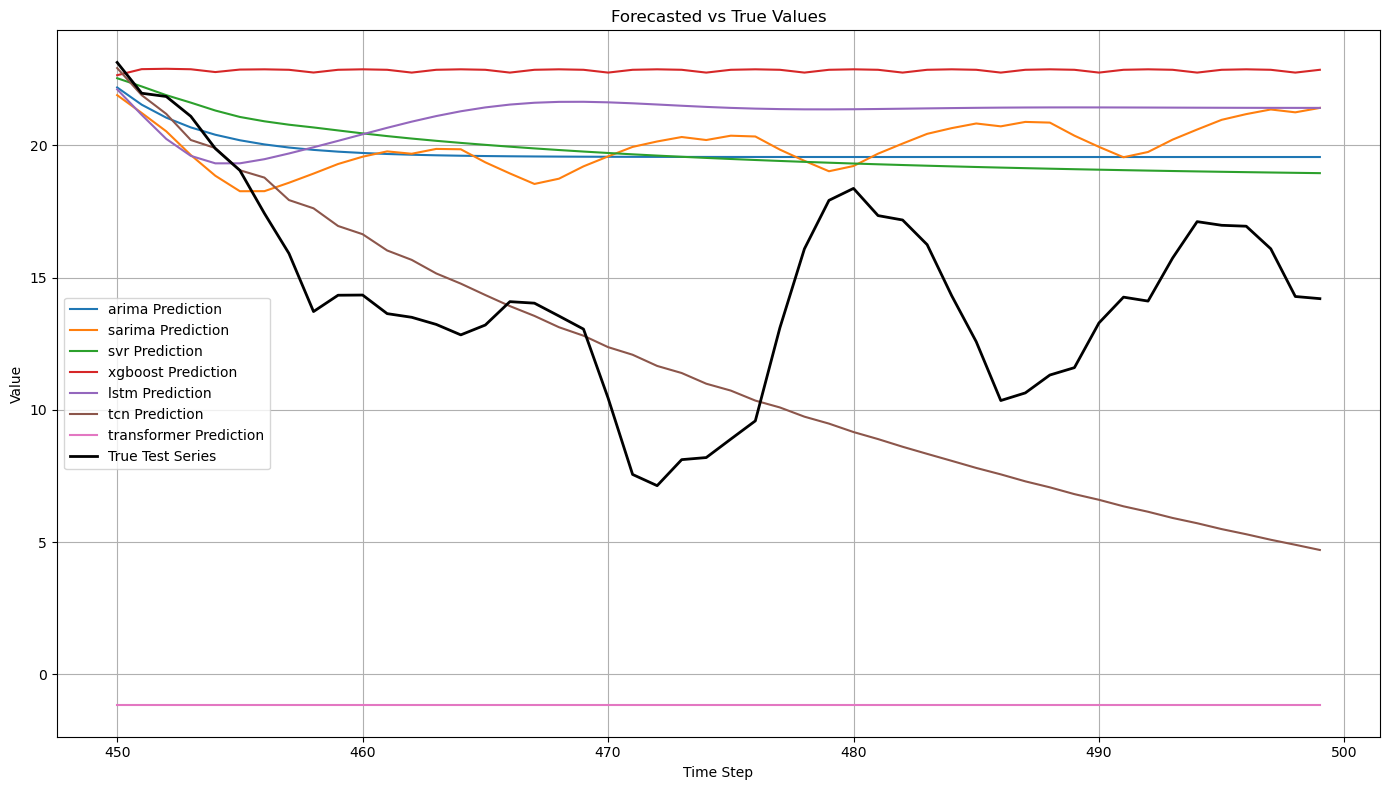

In [86]:
# Plot predictions for each model
plt.figure(figsize=(14, 8))

for model_name, y_pred in predictions.items():
    if y_pred is not None:
        plt.plot(range(len(train_series), len(train_series) + len(y_pred)), y_pred, label=f'{model_name} Prediction')

# Plot the true test series
plt.plot(range(len(train_series), len(train_series) + len(test_series)), test_series, label='True Test Series', color='black', linewidth=2)

plt.title("Forecasted vs True Values")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


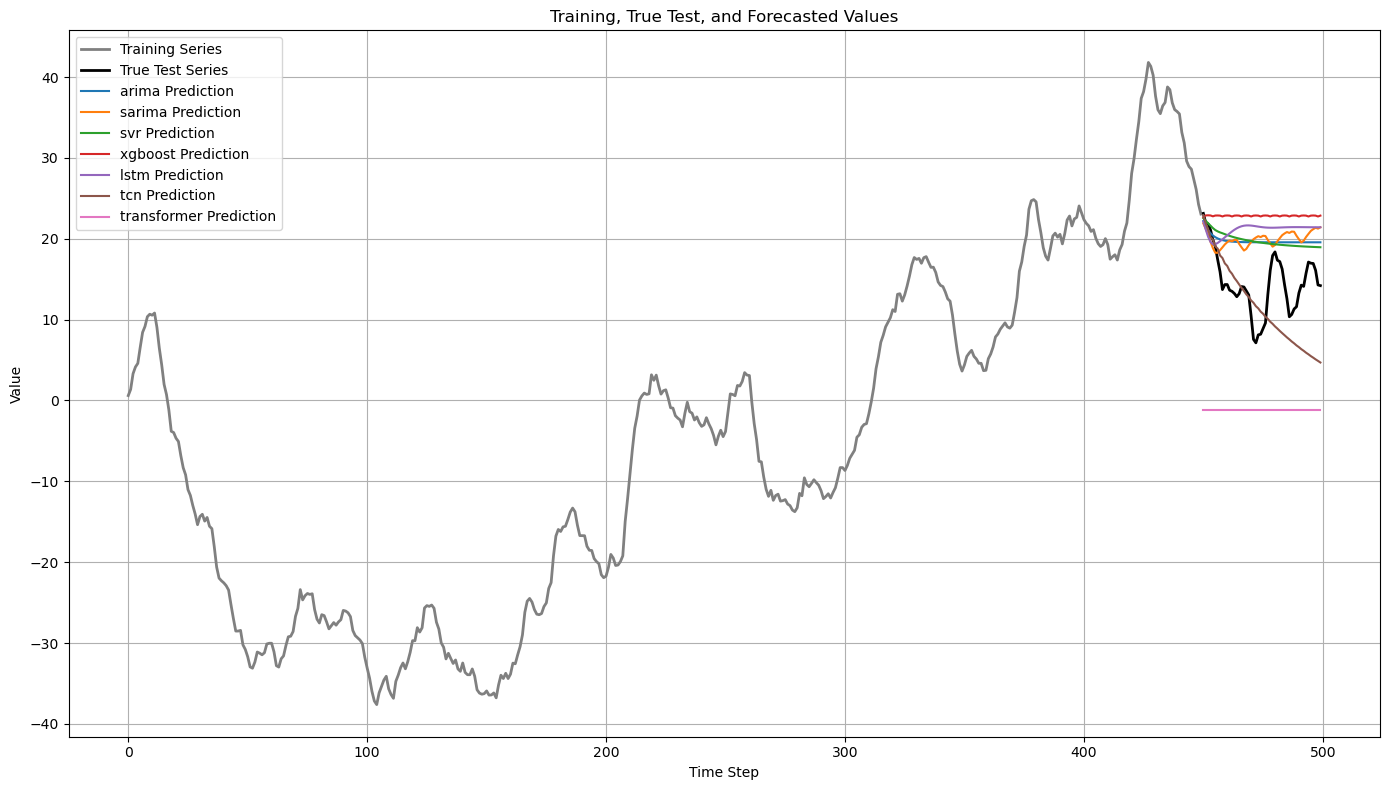

In [87]:
# Enhanced plot with training, test series, and all model predictions

plt.figure(figsize=(14, 8))

# Plot training data
plt.plot(range(len(train_series)), train_series, label='Training Series', color='gray', linewidth=2)

# Plot true test series
plt.plot(range(len(train_series), len(train_series) + len(test_series)), test_series, label='True Test Series', color='black', linewidth=2)

# Plot predictions for each model
for model_name, y_pred in predictions.items():
    if y_pred is not None:
        plt.plot(range(len(train_series), len(train_series) + len(y_pred)), y_pred, label=f'{model_name} Prediction')

plt.title("Training, True Test, and Forecasted Values")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/Users/edsonodake/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/edsonodake/miniforge3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


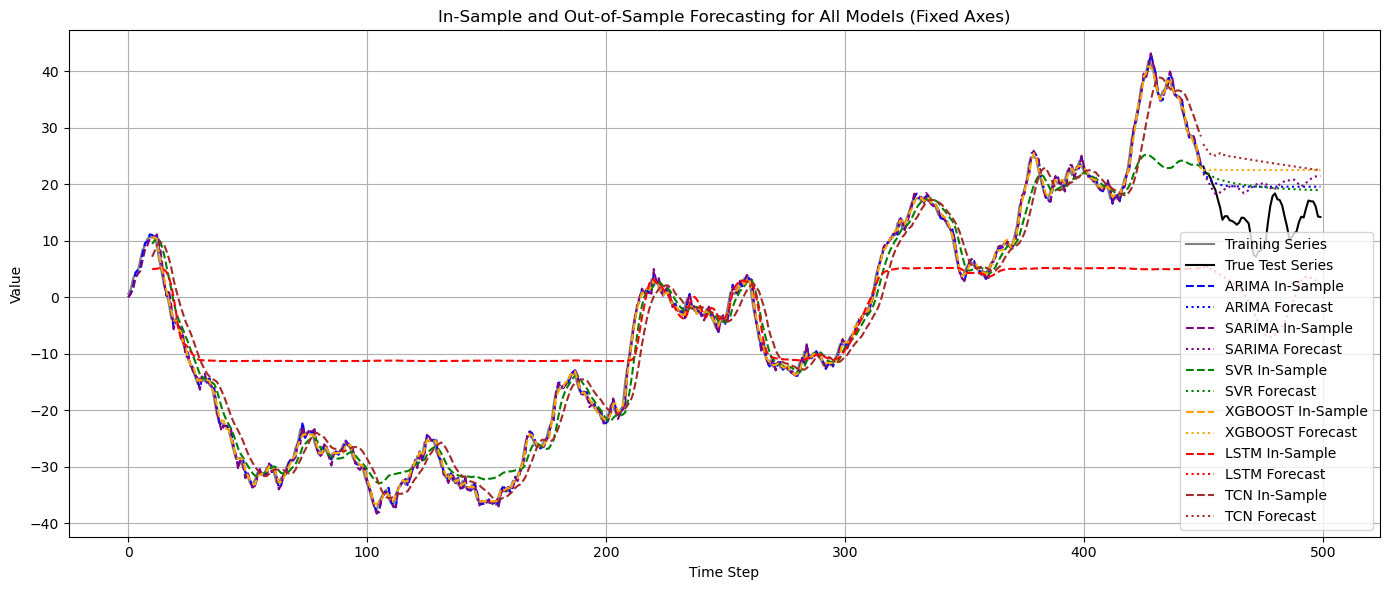

In [97]:
# Rebuild the trained_models dictionary and input data
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Flatten, Input, LayerNormalization, Dropout, MultiHeadAttention
from tensorflow.keras.models import Model
import tensorflow as tf

# Parameters
arima_order = (1, 1, 1)
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)
svr_params = {'C': 1.0, 'epsilon': 0.1, 'kernel': 'rbf'}
xgb_params = {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
deep_input_shape = (10, 1)
lag = 10

# Create models
trained_models = {
    'arima': ARIMA(train_series, order=arima_order).fit(),
    'sarima': SARIMAX(train_series, order=sarima_order, seasonal_order=seasonal_order).fit(disp=False),
    'svr': SVR(**svr_params),
    'xgboost': XGBRegressor(**xgb_params),
    'lstm': Sequential([
        LSTM(units=50, input_shape=deep_input_shape),
        Dense(1)
    ]),
    'tcn': Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=deep_input_shape),
        Flatten(),
        Dense(1)
    ]),
    'transformer': None  # Placeholder for transformer model, omitted here for simplicity
}

# Prepare data for ML models
X_train, y_train = [], []
for i in range(lag, len(train_series)):
    X_train.append(train_series[i - lag:i])
    y_train.append(train_series[i])
X_train = np.array(X_train)
y_train = np.array(y_train)

# Train ML models
trained_models['svr'].fit(X_train, y_train)
trained_models['xgboost'].fit(X_train, y_train)
trained_models['lstm'].compile(optimizer='adam', loss='mse')
trained_models['lstm'].fit(X_train.reshape(-1, lag, 1), y_train, epochs=10, verbose=0)
trained_models['tcn'].compile(optimizer='adam', loss='mse')
trained_models['tcn'].fit(X_train.reshape(-1, lag, 1), y_train, epochs=10, verbose=0)

# Generate the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plot training and test data
ax.plot(np.arange(len(train_series)), train_series, label='Training Series', color='gray')
ax.plot(np.arange(len(train_series), len(train_series) + len(test_series)), test_series, label='True Test Series', color='black')

model_colors = {
    'arima': 'blue',
    'sarima': 'purple',
    'svr': 'green',
    'xgboost': 'orange',
    'lstm': 'red',
    'tcn': 'brown',
}

for model_name, model in trained_models.items():
    if model is None:
        continue

    if model_name in ['arima', 'sarima']:
        y_pred = model.predict(start=0, end=len(train_series) - 1)
        y_forecast = model.forecast(steps=len(test_series))
        ax.plot(np.arange(len(train_series)), y_pred, linestyle='--', label=f'{model_name.upper()} In-Sample', color=model_colors[model_name])
        ax.plot(np.arange(len(train_series), len(train_series) + len(test_series)), y_forecast, linestyle=':', label=f'{model_name.upper()} Forecast', color=model_colors[model_name])
    else:
        y_pred, _ = predict_model(model_name, model, train_series, lag=lag, in_sample=True)
        y_forecast, _ = predict_model(model_name, model, train_series, steps_ahead=len(test_series), lag=lag, in_sample=False)
        ax.plot(np.arange(lag, lag + len(y_pred)), y_pred, linestyle='--', label=f'{model_name.upper()} In-Sample', color=model_colors[model_name])
        ax.plot(np.arange(len(train_series), len(train_series) + len(y_forecast)), y_forecast, linestyle=':', label=f'{model_name.upper()} Forecast', color=model_colors[model_name])

ax.set_title("In-Sample and Out-of-Sample Forecasting for All Models (Fixed Axes)")
ax.set_xlabel("Time Step")
ax.set_ylabel("Value")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


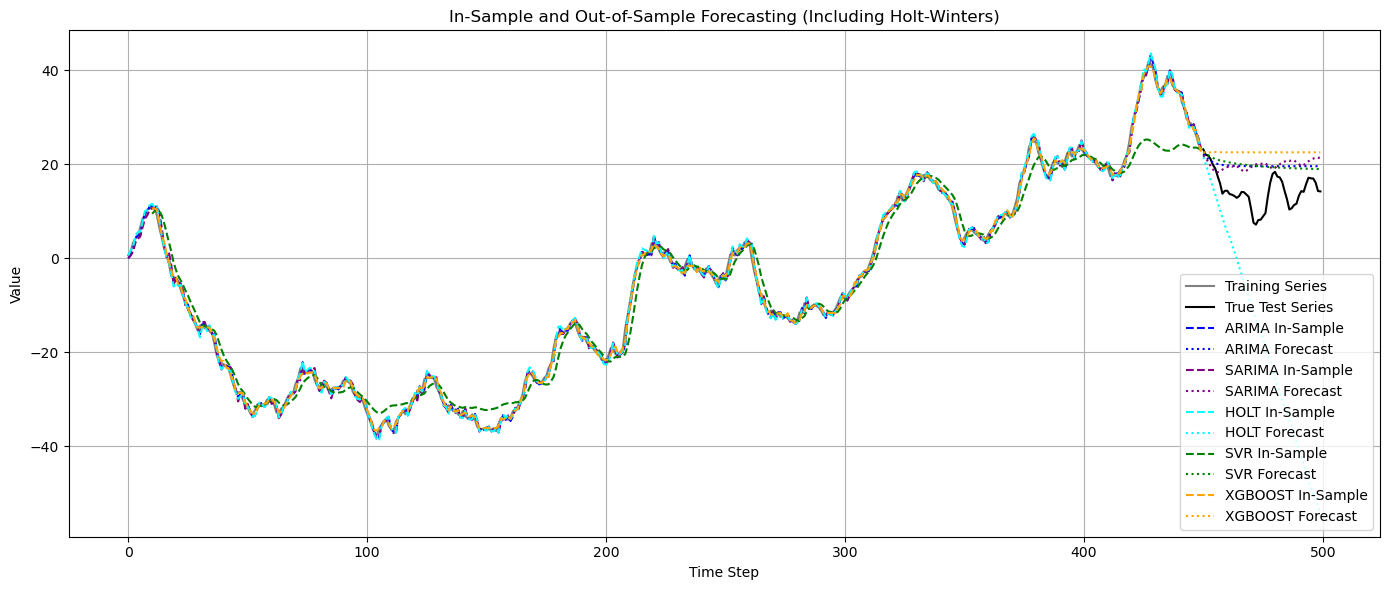

In [99]:
# Re-import dependencies after session reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Recreate helper function for non-deep models
def predict_model(model_name, model, input_series, steps_ahead=10, lag=10, in_sample=False):
    predictions = []
    if in_sample:
        X, y = [], []
        for i in range(lag, len(input_series)):
            X.append(input_series[i - lag:i])
            y.append(input_series[i])
        X = np.array(X)
        y = np.array(y)

        if model_name in ['svr', 'xgboost']:
            predictions = model.predict(X)
        return np.array(predictions), np.array(y)
    else:
        input_series = list(input_series[-lag:])
        for _ in range(steps_ahead):
            X_input = np.array(input_series[-lag:]).reshape(1, -1)
            if model_name in ['svr', 'xgboost']:
                pred = model.predict(X_input)[0]
            predictions.append(pred)
            input_series.append(pred)
        return np.array(predictions), None

# Generate synthetic ARIMA(1,1,1) data
def generate_stochastic_series(n=500, ar_params=[0.75], ma_params=[-0.25], d=1, noise_std=1.0, seed=42):
    if seed is not None:
        np.random.seed(seed)
    ar = np.r_[1, -np.array(ar_params)]
    ma = np.r_[1, np.array(ma_params)]
    arma_process = ArmaProcess(ar, ma)
    arma_sample = arma_process.generate_sample(nsample=n + d, scale=noise_std)
    if d > 0:
        for _ in range(d):
            arma_sample = np.cumsum(arma_sample)
    return pd.DataFrame({'value': arma_sample[d:]}, index=np.arange(n))

# Generate and split data
df = generate_stochastic_series()
series = df['value'].values
split_idx = int(len(series) * 0.9)
train_series = series[:split_idx]
test_series = series[split_idx:]

# Refit models
lag = 10
arima_order = (1, 1, 1)
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)
svr_params = {'C': 1.0, 'epsilon': 0.1, 'kernel': 'rbf'}
xgb_params = {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}

trained_models = {
    'arima': ARIMA(train_series, order=arima_order).fit(),
    'sarima': SARIMAX(train_series, order=sarima_order, seasonal_order=seasonal_order).fit(disp=False),
    'holt': ExponentialSmoothing(train_series, trend='add', seasonal='add', seasonal_periods=12).fit(),
    'svr': SVR(**svr_params),
    'xgboost': XGBRegressor(**xgb_params)
}

# Prepare training data for ML models
X_train, y_train = [], []
for i in range(lag, len(train_series)):
    X_train.append(train_series[i - lag:i])
    y_train.append(train_series[i])
X_train = np.array(X_train)
y_train = np.array(y_train)

# Fit SVR and XGBoost
trained_models['svr'].fit(X_train, y_train)
trained_models['xgboost'].fit(X_train, y_train)

# Colors for plotting
model_colors = {
    'arima': 'blue',
    'sarima': 'purple',
    'holt': 'cyan',
    'svr': 'green',
    'xgboost': 'orange'
}

# Plot all
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(np.arange(len(train_series)), train_series, label='Training Series', color='gray')
ax.plot(np.arange(len(train_series), len(train_series) + len(test_series)), test_series, label='True Test Series', color='black')

for model_name, model in trained_models.items():
    if model_name in ['arima', 'sarima', 'holt']:
        y_pred = model.predict(start=0, end=len(train_series) - 1) if model_name != 'holt' else model.fittedvalues
        y_forecast = model.forecast(steps=len(test_series))
        ax.plot(np.arange(len(train_series)), y_pred, linestyle='--', label=f'{model_name.upper()} In-Sample', color=model_colors[model_name])
        ax.plot(np.arange(len(train_series), len(train_series) + len(test_series)), y_forecast, linestyle=':', label=f'{model_name.upper()} Forecast', color=model_colors[model_name])
    else:
        y_pred, _ = predict_model(model_name, model, train_series, lag=lag, in_sample=True)
        y_forecast, _ = predict_model(model_name, model, train_series, steps_ahead=len(test_series), lag=lag, in_sample=False)
        ax.plot(np.arange(lag, lag + len(y_pred)), y_pred, linestyle='--', label=f'{model_name.upper()} In-Sample', color=model_colors[model_name])
        ax.plot(np.arange(len(train_series), len(train_series) + len(y_forecast)), y_forecast, linestyle=':', label=f'{model_name.upper()} Forecast', color=model_colors[model_name])

ax.set_title("In-Sample and Out-of-Sample Forecasting (Including Holt-Winters)")
ax.set_xlabel("Time Step")
ax.set_ylabel("Value")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()
